In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv


/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/nyse/securities.csv
Using device: cuda
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB
None
                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


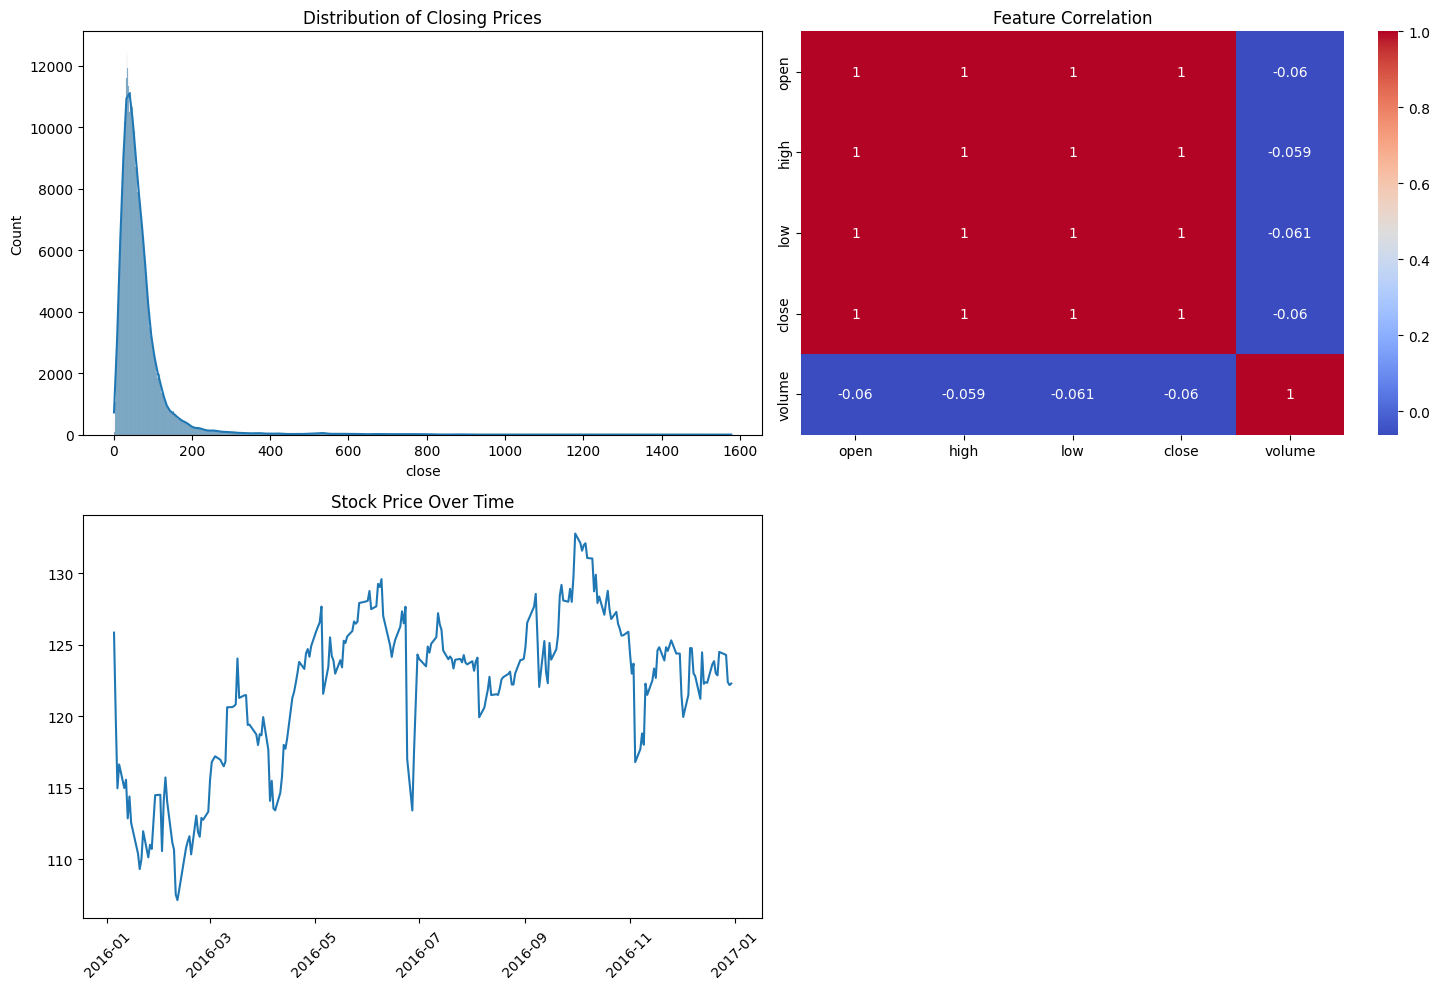

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

# Check for GPU and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Part one Regression (your original code, with GPU fixes and saving)

# Load data
df = pd.read_csv('/kaggle/input/nyse/prices.csv')

# Basic info
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Visualizations
plt.figure(figsize=(15, 10))

# Distribution of closing prices
plt.subplot(2, 2, 1)
sns.histplot(df['close'], kde=True)
plt.title('Distribution of Closing Prices')

# Correlation heatmap
plt.subplot(2, 2, 2)
sns.heatmap(df[['open', 'high', 'low', 'close', 'volume']].corr(), 
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation')

# Price trends over time
plt.subplot(2, 2, 3)
# Fix: Use format='ISO8601' to handle mixed date formats
df['date'] = pd.to_datetime(df['date'], format='ISO8601')
sample_stock = df[df['symbol'] == df['symbol'].iloc[0]]
plt.plot(sample_stock['date'], sample_stock['close'])
plt.title('Stock Price Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('/kaggle/working/eda_plots.png')  # Save plot
plt.show()

# Prepare data for regression
features = ['open', 'high', 'low', 'volume']
X = df[features].values
y = df['close'].values

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors and move to device
X_train_t = torch.FloatTensor(X_train).to(device)
y_train_t = torch.FloatTensor(y_train).to(device)
X_test_t = torch.FloatTensor(X_test).to(device)
y_test_t = torch.FloatTensor(y_test).to(device)

# Define regression model
class RegressionDNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate=0.2):
        super(RegressionDNN, self).__init__()
        layers = []
        
        prev_size = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size
        
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

# Example training (adapt from your hyperparam search if needed)
model_reg = RegressionDNN(input_size=4, hidden_sizes=[64, 32, 16]).to(device)  # Move to GPU
optimizer = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=0.01)  # L2 reg
criterion = nn.MSELoss()

# Train
for epoch in range(100):
    model_reg.train()
    optimizer.zero_grad()
    outputs = model_reg(X_train_t).squeeze()
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()

# Evaluate
model_reg.eval()
with torch.no_grad():
    test_pred = model_reg(X_test_t).squeeze()
    test_loss = criterion(test_pred, y_test_t).item()



In [3]:
print("Regression Test Loss:", test_loss)


Regression Test Loss: 0.014178136363625526


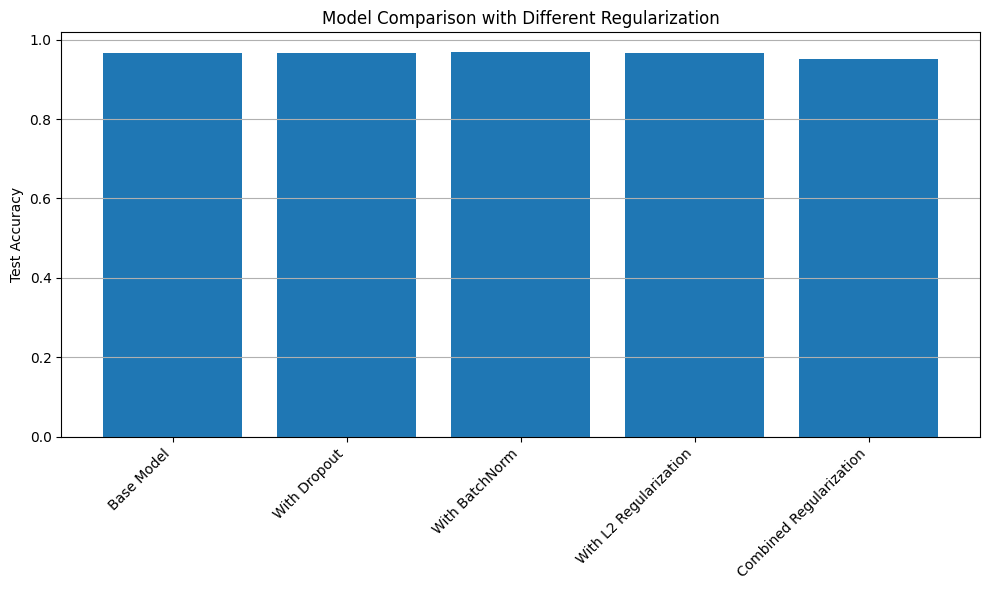

In [6]:
# Save regression model
torch.save(model_reg.state_dict(), '/kaggle/working/regression_model.pth')

# Part two Classification (fixed/completed from your snippet)

# Load classification data (assuming from your other dataset)
df_class = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

# Prepare data (example: predict 'Failure Type' or binary failure)
# Adjust features/target as per your needs
features_class = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X_class = df_class[features_class].values
y_class = df_class['Failure Type']  # Multi-class example

# Encode labels
le = LabelEncoder()
y_class = le.fit_transform(y_class)
num_classes = len(np.unique(y_class))

# Split and scale
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
scaler_X_c = StandardScaler()
X_train_c = scaler_X_c.fit_transform(X_train_c)
X_test_c = scaler_X_c.transform(X_test_c)

# Tensors to device
X_train_ct = torch.FloatTensor(X_train_c).to(device)
y_train_ct = torch.LongTensor(y_train_c).to(device)
X_test_ct = torch.FloatTensor(X_test_c).to(device)
y_test_ct = torch.LongTensor(y_test_c).to(device)

# Base Classifier
class BaseClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Function to train and evaluate a classifier (reusable)
def train_eval_classifier(model, X_train, y_train, X_test, y_test, epochs=50, lr=0.001, weight_decay=0):
    model = model.to(device)  # Ensure GPU
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
    
    model.eval()
    with torch.no_grad():
        pred = torch.argmax(model(X_test), dim=1).cpu().numpy()
        acc = accuracy_score(y_test.cpu().numpy(), pred)
    
    return acc

# Train base model
base_model = BaseClassifier(input_size=5, num_classes=num_classes)
base_model_accuracy = train_eval_classifier(base_model, X_train_ct, y_train_ct, X_test_ct, y_test_ct)
torch.save(base_model.state_dict(), '/kaggle/working/base_classifier.pth')

# Model with Dropout
class DropoutClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DropoutClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.dropout1(torch.relu(self.fc1(x)))
        x = self.dropout2(torch.relu(self.fc2(x)))
        return self.fc3(x)

dropout_model = DropoutClassifier(input_size=5, num_classes=num_classes)
dropout_accuracy = train_eval_classifier(dropout_model, X_train_ct, y_train_ct, X_test_ct, y_test_ct)
torch.save(dropout_model.state_dict(), '/kaggle/working/dropout_classifier.pth')

# Model with BatchNorm
class BatchNormClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BatchNormClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

batchnorm_model = BatchNormClassifier(input_size=5, num_classes=num_classes)
batchnorm_accuracy = train_eval_classifier(batchnorm_model, X_train_ct, y_train_ct, X_test_ct, y_test_ct)
torch.save(batchnorm_model.state_dict(), '/kaggle/working/batchnorm_classifier.pth')

# Model with L2
l2_model = BaseClassifier(input_size=5, num_classes=num_classes)  # Reuse base
l2_accuracy = train_eval_classifier(l2_model, X_train_ct, y_train_ct, X_test_ct, y_test_ct, weight_decay=0.01)
torch.save(l2_model.state_dict(), '/kaggle/working/l2_classifier.pth')

# Combined Regularization Model (your original)
class RegularizedClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RegularizedClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.4)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = self.fc4(x)
        return x

combined_model = RegularizedClassifier(input_size=5, num_classes=num_classes)
combined_accuracy = train_eval_classifier(combined_model, X_train_ct, y_train_ct, X_test_ct, y_test_ct, weight_decay=0.01)
torch.save(combined_model.state_dict(), '/kaggle/working/combined_classifier.pth')

# Compare models
models_comparison = {
    'Base Model': base_model_accuracy,
    'With Dropout': dropout_accuracy,
    'With BatchNorm': batchnorm_accuracy,
    'With L2 Regularization': l2_accuracy,
    'Combined Regularization': combined_accuracy
}

# Save results to CSV
pd.DataFrame.from_dict(models_comparison, orient='index', columns=['Accuracy']).to_csv('/kaggle/working/classification_results.csv')

plt.figure(figsize=(10, 6))
plt.bar(models_comparison.keys(), models_comparison.values())
plt.ylabel('Test Accuracy')
plt.title('Model Comparison with Different Regularization')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig('/kaggle/working/comparison_plot.png')  # Save plot
plt.show()